In [1]:
import os
import torchvision
from transformers import AutoImageProcessor, AutoModelForObjectDetection, AutoFeatureExtractor, YolosImageProcessor
import numpy as np
from PIL import Image, ImageDraw
import pytorch_lightning as pl
import torch
from pytorch_lightning import Trainer
import torchvision.transforms.functional as TF
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

2024-02-09 09:28:31.981185: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-09 09:28:32.610134: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-09 09:28:32.610289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-09 09:28:32.715324: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-09 09:28:33.007779: I tensorflow/core/platform/cpu_feature_guar

In [2]:
#need to do this to use AutoImageProcessor 
from huggingface_hub import notebook_login
notebook_login()

In [3]:
# checkpoint = saved state or config during model training
checkpoint = "hustvl/yolos-tiny"

In [4]:
# preparing input features for the model -> same as the pretrained model above
image_processor = AutoImageProcessor.from_pretrained("hustvl/yolos-tiny", config="./config.json")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [5]:
# pre-trained YOLO model
yolo = AutoModelForObjectDetection.from_pretrained("hustvl/yolos-tiny")

In [6]:
def draw_bbox(image, bbox, txt_labels=None):
  '''
      Function to draw a bbox around an object (Lego piece)
      Convert the image into a tensor and scale the pixels values
      to be within 0 and 255

      Use the pytorch function draw_bounding_boxes passing to it the 
      processed image, the boxes values and the object label 

      Put back the original 

  '''
  x = (TF.to_tensor(image) * 255.).to(torch.uint8)
  bbox = bbox.to(torch.int)

  res = draw_bounding_boxes(x, bbox, txt_labels)
  # reorder the dimentions of the tensor, put it on CPU (if it was on GPU)
  # transform it into a numpy array
  return res.permute(1,2,0).cpu().numpy()

In [7]:
def make_prediction(image, net, id2label, trashold=0.9):
    """
    image: PIL.Image
    net: torch.nn.Module
    id2label: dict

    TODO: lower the trashold so that it will predict also low conficence boxes
    """

    # use the image_processor object to preprocess the image 
    # the returned output should be a pytorch tensor
    inputs = image_processor(images=image, return_tensors="pt")

    # pass the process image into the neural network
    outputs = net(**inputs)

    # save the size of the input image -> needed in the object detection step
    target_sizes = torch.tensor([image.size[::-1]])

    # takes the raw outputs from the model and processes them for a readable result
    # take only the first (possibly only) value from the result list
    
    results = image_processor.post_process_object_detection(outputs, threshold=trashold, target_sizes=target_sizes)[0]
    print(results)

    #print information about the detected object
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [round(i, 2) for i in box.tolist()]
        print(
            f"Detected {id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
        )

    # extract the label from the index
    txt_labels = [id2label[label.item()] for label in results["labels"]]

    # draw the bbox on the image
    pred_on_image = draw_bbox(image, results["boxes"], txt_labels)

    # return the image in for on a PIL image
    return Image.fromarray(pred_on_image)

In [8]:
# name all the classes with the name of the lego piece
classes = ["X1-Y1-Z2", 
           "X1-Y2-Z1", 
           "X1-Y2-Z2", 
           "X1-Y2-Z2-CHAMFER",
           "X1-Y2-Z2-TWINFILLET", 
           "X1-Y3-Z2", 
           "X1-Y3-Z2-FILLET", 
           "X1-Y4-Z1", 
           "X1-Y4-Z2", 
           "X2-Y2-Z2", 
           "X2-Y2-Z2-FILLET"]
# prepare two dicts with class name and number both as key and as value
id2label = {}
label2id = {}
for i in range(len(classes)):
  id2label.update({i : classes[i]})
  label2id.update({classes[i] : i})
print(f"id2label={id2label}, label2id={label2id}")

id2label={0: 'X1-Y1-Z2', 1: 'X1-Y2-Z1', 2: 'X1-Y2-Z2', 3: 'X1-Y2-Z2-CHAMFER', 4: 'X1-Y2-Z2-TWINFILLET', 5: 'X1-Y3-Z2', 6: 'X1-Y3-Z2-FILLET', 7: 'X1-Y4-Z1', 8: 'X1-Y4-Z2', 9: 'X2-Y2-Z2', 10: 'X2-Y2-Z2-FILLET'}, label2id={'X1-Y1-Z2': 0, 'X1-Y2-Z1': 1, 'X1-Y2-Z2': 2, 'X1-Y2-Z2-CHAMFER': 3, 'X1-Y2-Z2-TWINFILLET': 4, 'X1-Y3-Z2': 5, 'X1-Y3-Z2-FILLET': 6, 'X1-Y4-Z1': 7, 'X1-Y4-Z2': 8, 'X2-Y2-Z2': 9, 'X2-Y2-Z2-FILLET': 10}


In [9]:
class CocoDetection(torchvision.datasets.CocoDetection):
    '''
    The purpose of this custom class is to extend the functionality 
    of the base class and provide additional customization for working 
    with COCO datasets in PyTorch.

    init parameters: folder with the images 
                    a transformation to be applied to the images
                    train_or_test to specify the name of the annotation json
    '''
    # initialize a CocoDetection object
    def __init__(self, image_folder, transform, train_or_test):
        # save the path for the annotation file
        coco_ann=os.path.join(image_folder, f"coco_{train_or_test}.json")
        super(CocoDetection, self).__init__(image_folder, coco_ann)
        # save the transformation to be applied to the images
        self.T = transform

    def __getitem__(self, index: int):
        img, target = super(CocoDetection, self).__getitem__(index)

        # get image id
        image_id = self.ids[index]

        # create a dict with the image id and its annotations
        target={'image_id': image_id, 'annotations':target}

        # apply the transformation to the image 
        encoding = self.T(images = img, annotations=target, return_tensors="pt")

        # extract the pixel values and the label from the transformed image
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target

In [10]:
# inizialize a transformer for feature extraction
transform = AutoFeatureExtractor.from_pretrained("hustvl/yolos-small", size=512, max_size=864)

/home/carlotta/Documents/vision_project/env/lib/python3.10/site-packages/transformers/models/yolos/feature_extraction_yolos.py:38: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  warnings.warn(


In [11]:
# Instantiate a CocoDetection object for training
# image_folder=specifies the folder with training images
# transform=transform specifies the transformation to be applied to the images
# train_or_test=specifies the name of the annotation json file for training

train_dataset = CocoDetection(image_folder='./train', transform=transform, train_or_test="train")
test_dataset = CocoDetection(image_folder='./test', transform=transform, train_or_test="test")

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [12]:
print("Number of training examples:", len(train_dataset))
print("Number of test examples:", len(test_dataset))

Number of training examples: 370
Number of test examples: 130


In [13]:
image_ids = test_dataset.coco.getImgIds()
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = test_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join('./test', image['file_name']))

Image n°70


[{'iscrowd': 0, 'image_id': 70, 'bbox': [496.0126953125, 493.8359680175781, 26.11004638671875, 34.190673828125], 'segmentation': [], 'category_id': 4, 'id': 70, 'area': 892}]
{0: {'id': 0, 'name': 'X1-Y1-Z2', 'supercategory': 'X1-Y1-Z2'}, 1: {'id': 1, 'name': 'X1-Y2-Z1', 'supercategory': 'X1-Y2-Z1'}, 2: {'id': 2, 'name': 'X1-Y2-Z2', 'supercategory': 'X1-Y2-Z2'}, 3: {'id': 3, 'name': 'X1-Y2-Z2-CHAMFER', 'supercategory': 'X1-Y2-Z2-CHAMFER'}, 4: {'id': 4, 'name': 'X1-Y2-Z2-TWINFILLET', 'supercategory': 'X1-Y2-Z2-TWINFILLET'}, 5: {'id': 5, 'name': 'X1-Y3-Z2', 'supercategory': 'X1-Y3-Z2'}, 6: {'id': 6, 'name': 'X1-Y3-Z2-FILLET', 'supercategory': 'X1-Y3-Z2-FILLET'}, 7: {'id': 7, 'name': 'X1-Y4-Z1', 'supercategory': 'X1-Y4-Z1'}, 8: {'id': 8, 'name': 'X1-Y4-Z2', 'supercategory': 'X1-Y4-Z2'}, 9: {'id': 9, 'name': 'X2-Y2-Z2', 'supercategory': 'X2-Y2-Z2'}, 10: {'id': 10, 'name': 'X2-Y2-Z2-FILLET', 'supercategory': 'X2-Y2-Z2-FILLET'}}
[496.0126953125, 493.8359680175781, 26.11004638671875, 34.19067

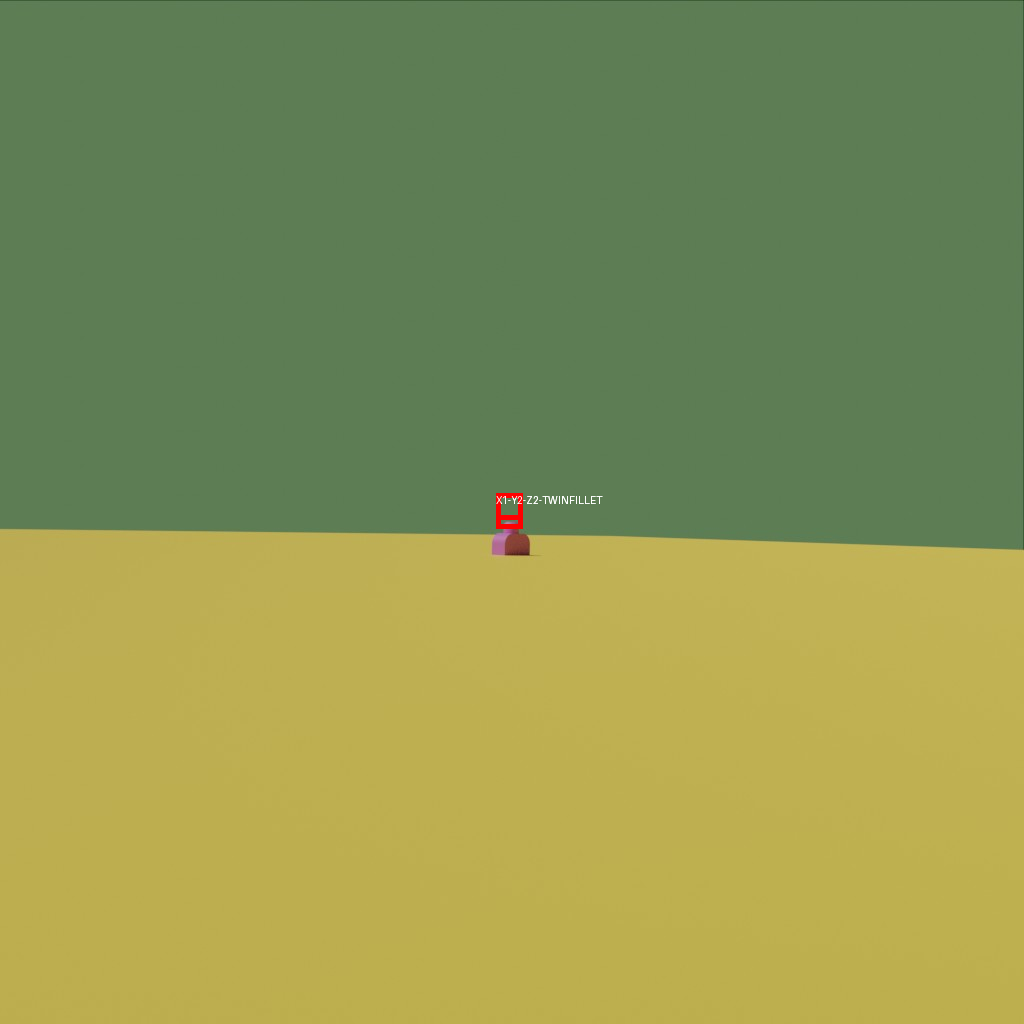

In [14]:
annotations = test_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")
print(annotations)

cats = test_dataset.coco.cats
print(cats)

id2label = {k: v['name'] for k,v in cats.items()}
id2label

id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  print(box)
  class_idx = annotation['category_id']
  x,y,w,h = box
  image_size = 1024
  print(f"x={x}, y={y}, w={w}, h={h}")
  draw.rectangle((x,y,x+w,y+h), outline='red', width=5)
  draw.text((x, y), id2label[class_idx], fill='white')
  draw.rectangle((x,y,x+w,y+w), outline='red', width=5)
  draw.text((x, y), id2label[class_idx], fill='white')

image

In [15]:
pixel_values, target = train_dataset[0]
pixel_values

tensor([[[ 0.3823,  0.3823,  0.3823,  ...,  0.3823,  0.3823, -0.1999],
         [ 1.0159,  1.0159,  1.0159,  ...,  1.0159,  1.0159,  0.4337],
         [ 0.9817,  0.9817,  0.9817,  ...,  0.9988,  0.9988,  0.3994],
         ...,
         [ 1.2214,  1.2214,  1.2214,  ...,  1.2385,  1.2385,  1.2385],
         [ 1.2214,  1.2214,  1.2214,  ...,  1.2385,  1.2385,  1.2385],
         [ 1.2214,  1.2214,  1.2214,  ...,  1.2385,  1.2385,  1.2385]],

        [[-0.4426, -0.4426, -0.4426,  ..., -0.4426, -0.4426, -1.0378],
         [ 0.2052,  0.2052,  0.2052,  ...,  0.2052,  0.2052, -0.3901],
         [ 0.1702,  0.1702,  0.1702,  ...,  0.1877,  0.1877, -0.4251],
         ...,
         [ 0.5028,  0.5028,  0.5028,  ...,  0.4678,  0.4678,  0.4678],
         [ 0.5028,  0.5028,  0.5028,  ...,  0.4678,  0.4678,  0.4678],
         [ 0.5028,  0.5028,  0.5028,  ...,  0.4678,  0.4678,  0.4678]],

        [[ 0.9494,  0.9494,  0.9494,  ...,  0.9494,  0.9494,  0.3568],
         [ 1.5942,  1.5942,  1.5942,  ...,  1

In [16]:
target

{'size': tensor([1024, 1024]), 'image_id': tensor([1]), 'class_labels': tensor([0]), 'boxes': tensor([[0.4954, 0.5214, 0.0360, 0.0528]]), 'area': tensor([1992.]), 'iscrowd': tensor([0]), 'orig_size': tensor([1024, 1024])}

In [17]:
def collate_fn(batch):
  # Extract pixel_values from each item in the batch
  pixel_values = [item[0] for item in batch]

  # Extract labels from each item in the batch
  labels = [item[1] for item in batch]

  encoding = transform.pad(pixel_values, return_tensors="pt")
  
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['labels'] = labels
  return batch

In [18]:
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=1, shuffle=True)
val_dataloader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=1)
batch = next(iter(train_dataloader))

batch.keys()

dict_keys(['pixel_values', 'labels'])

In [19]:
batch = next(iter(train_dataloader))
batch

{'pixel_values': tensor([[[[-0.1999, -0.1999, -0.1999,  ..., -0.3027, -0.3198, -0.6794],
           [ 0.1768,  0.1768,  0.1768,  ...,  0.0569,  0.0227, -0.3369],
           [ 0.2282,  0.2282,  0.2282,  ...,  0.1426,  0.1254, -0.2513],
           ...,
           [ 1.1529,  1.1529,  1.1529,  ...,  1.1529,  1.1529,  1.1529],
           [ 1.1529,  1.1529,  1.1529,  ...,  1.1529,  1.1529,  1.1529],
           [ 1.1529,  1.1529,  1.1529,  ...,  1.1529,  1.1529,  1.1529]],
 
          [[-1.6681, -1.6681, -1.6681,  ..., -1.6155, -1.5805, -1.9132],
           [-1.2829, -1.2829, -1.2829,  ..., -1.2829, -1.2304, -1.5980],
           [-1.2829, -1.2829, -1.2829,  ..., -1.2479, -1.2129, -1.5630],
           ...,
           [ 0.1176,  0.1176,  0.1176,  ...,  0.1352,  0.1352,  0.1352],
           [ 0.1176,  0.1176,  0.1176,  ...,  0.1352,  0.1352,  0.1352],
           [ 0.1176,  0.1176,  0.1176,  ...,  0.1352,  0.1352,  0.1352]],
 
          [[ 0.6008,  0.6008,  0.6008,  ...,  0.5311,  0.5485,  0.1651

In [20]:
batch["pixel_values"].shape

torch.Size([1, 3, 1024, 1024])

In [21]:
batch["labels"]

[{'size': tensor([1024, 1024]), 'image_id': tensor([215]), 'class_labels': tensor([5]), 'boxes': tensor([[0.5028, 0.4927, 0.0288, 0.0264]]), 'area': tensor([798.]), 'iscrowd': tensor([0]), 'orig_size': tensor([1024, 1024])}]

In [22]:
class YoloTrainer(pl.LightningModule):

     def __init__(self, lr, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         self.model = AutoModelForObjectDetection.from_pretrained("hustvl/yolos-small",
                                                                id2label=id2label,
                                                                label2id=label2id,
                                                                num_labels=len(id2label),
                                                                ignore_mismatched_sizes=True)
         # learning rate and weight decay
         self.lr = lr
         self.weight_decay = weight_decay

     def forward(self, pixel_values):
       outputs = self.model(pixel_values=pixel_values)
       return outputs

     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

In [23]:
yolo_legos = YoloTrainer(lr=2.5e-5, weight_decay=1e-4)


/home/carlotta/Documents/vision_project/env/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-small and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 384]) in the checkpoint and torch.Size([12, 384]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([12]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# outputs = yolo_legos(pixel_values=batch['pixel_values'])

In [24]:
trainer = Trainer(accelerator="auto", max_steps=3, gradient_clip_val=0.1)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [25]:
trainer.fit(yolo_legos)


  | Name  | Type                    | Params
--------------------------------------------------
0 | model | YolosForObjectDetection | 30.7 M
--------------------------------------------------
30.7 M    Trainable params
0         Non-trainable params
30.7 M    Total params
122.616   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/carlotta/Documents/vision_project/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/carlotta/Documents/vision_project/env/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/carlotta/Documents/vision_project/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

: 

In [1]:
image_ids = test_dataset.coco.getImgIds()
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
test_image = test_dataset.coco.loadImgs(image_id)[0]
test_image = Image.open(os.path.join('./test', test_image['file_name']))
test_image

NameError: name 'test_dataset' is not defined

In [ ]:
ckpt = torch.load("lightning_logs/version_6/checkpoints/epoch=0-step=150.ckpt")["state_dict"]
yolo_legos.load_state_dict(ckpt)

In [ ]:
pred_lego = make_prediction(test_image, yolo_legos, id2label)


In [ ]:
pred_lego